# 주택 가격 예측: 회귀 문제

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from keras.datasets import boston_housing
(train_x,train_y), (test_x,test_y) = boston_housing.load_data()
print('train :',train_x.shape)
print('test :',test_x.shape)

train : (404, 13)
test : (102, 13)


In [ ]:
# 1. Per capita crime rate.
# 2. Proportion of residential land zoned for lots over 25,000 square feet.
# 3. Proportion of non-retail business acres per town.
# 4. Charles River dummy variable (= 1 if tract bounds river; 0 otherwise).
# 5. Nitric oxides concentration (parts per 10 million).
# 6. Average number of rooms per dwelling.
# 7. Proportion of owner-occupied units built prior to 1940.
# 8. Weighted distances to five Boston employment centres.
# 9. Index of accessibility to radial highways.
# 10. Full-value property-tax rate per $10,000.
# 11. Pupil-teacher ratio by town.
# 12. 1000 * (Bk - 0.63) ** 2 where Bk is the proportion of Black people by town.
# 13. % lower status of the population.

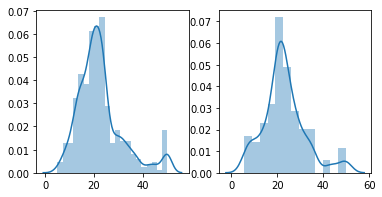

In [12]:
plt.figure(figsize=(6,3))
plt.subplot(1,2,1) ; sns.distplot(train_y)
plt.subplot(1,2,2) ; sns.distplot(test_y)

In [14]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(train_x)
scale_train_x = scaler.transform(train_x)
scale_test_x = scaler.transform(test_x)

## Modeling

In [22]:
from keras import models, layers
def my_model() :
    model = models.Sequential()
    model.add(layers.Dense(64,activation='relu',input_shape=(train_x.shape[1],)))
    model.add(layers.Dense(64,activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop',loss='mse',metrics=['mae'])
    return model

In [25]:
#### 데이터 크기가 작을 때는 검증 데이터를 따로 만들기 보다는 K-fold Validation
k = 4
num_val_samples = len(scale_train_x) // k
num_epochs = 100
all_scores = []

for i in range(k):
    print('처리중인 폴드 #', i)
    # 검증 데이터 준비: k번째 분할
    val_data = scale_train_x[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_y[i * num_val_samples: (i + 1) * num_val_samples]

    # 훈련 데이터 준비: 다른 분할 전체
    partial_train_data = np.concatenate(
        [scale_train_x[:i * num_val_samples],
         scale_train_x[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_y[:i * num_val_samples],
         train_y[(i + 1) * num_val_samples:]],
        axis=0)

    # 모델 구성
    model = my_model()
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=1, verbose=0)
    # 검증 세트로 모델 평가
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

처리중인 폴드 # 0
처리중인 폴드 # 1
처리중인 폴드 # 2
처리중인 폴드 # 3


In [27]:
print(all_scores)
print('total mae mean :',np.mean(all_scores))

[2.1720735719888515, 2.7181786263343133, 2.578809405317401, 2.434299677315325]
total mae mean : 2.4758403202389725


In [30]:
# 각 폴드에서 validation score를 로그에 저장

num_epochs = 300
all_mae_histories = []

for i in range(k):
    print('처리중인 폴드 #', i)
    # 검증 데이터 준비: k번째 분할
    val_data = scale_train_x[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_y[i * num_val_samples: (i + 1) * num_val_samples]

    # 훈련 데이터 준비: 다른 분할 전체
    partial_train_data = np.concatenate(
        [scale_train_x[:i * num_val_samples],
         scale_train_x[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_y[:i * num_val_samples],
         train_y[(i + 1) * num_val_samples:]],
        axis=0)

    # 모델 구성
    model = my_model()
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)

처리중인 폴드 # 0
처리중인 폴드 # 1
처리중인 폴드 # 2
처리중인 폴드 # 3


In [33]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

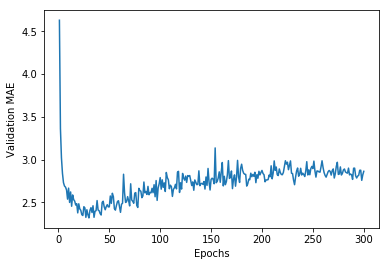

In [34]:
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

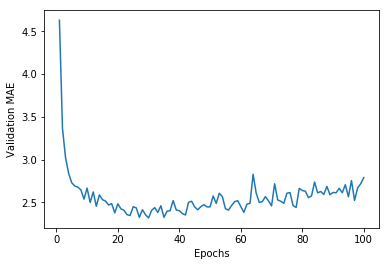

In [36]:
plt.plot(range(1, 100 + 1), average_mae_history[:100])
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [37]:
model = my_model()
model.fit(scale_train_x, train_y,
                        epochs=50, batch_size=1, verbose=0)
model.evaluate(scale_test_x,test_y)

102/102 [==============================] - 0s 568us/step


[16.708394518085555, 2.5855751879074993]